In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
from collections import Counter
import pandas as pd
import matplotlib.patches as patches
import seaborn as sns
import copy
import torch
from dotmap import DotMap
import os
import json
from skimage import measure
import pickle
from scipy.sparse import csr_matrix
from scipy.stats import hmean
from matplotlib.colors import colorConverter
import matplotlib as mpl
from itertools import chain
import json

In [2]:
sys.path.append("..")
from train_unet import UNetHandler
from train_faster import FasterHandler

In [3]:
from notebooks.utils import get_unet_masks, apply_nms

In [4]:
MASK_CMAP = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[colorConverter.to_rgba('white'),colorConverter.to_rgba('red')],256)
MASK_CMAP._init()
MASK_CMAP._lut[:,-1] = 0.2

In [5]:
model_handlers = {
    "ResidualUNet": UNetHandler,
    "fasterRCNN": FasterHandler,
}

In [6]:
def get_options(checkpoint_dir):
    checkpoint_name = 'model_latest.pt' if "ResidualUNet" in checkpoint_dir else 'model_best.pt'
    opt_dir=os.path.join(checkpoint_dir, 'opt.json')
    weights_dir=os.path.join(checkpoint_dir, checkpoint_name)
    with open(opt_dir, 'r') as fd:
        opt = json.load(fd)
    # add .. before relative paths, as we are in ./notebooks folder
    opt = DotMap({
        # Defaults
        "trainable_backbone_layers": None,
        "lr_scheduler": False,
        "optimizer": "SGD",
        **{k: '.' + v if type(v) == str and v[:2] == './' else v for k, v in opt.items()},
        # Overwrite
        "purpose": "val",
        "phase": "val",
        "log_dash": False,
        "device": "cpu",
        "step_batch_size": 1
    })
    if "trainable_backbone_layers" not in opt:
        opt.trainable_backbone_layers = None
    # add checkpoint
    opt.checkpoint = weights_dir
    return opt

In [7]:
models_to_compare=[
    "ResidualUNet_v1.0.12_2021-05-24 11:09:47",
]
models_to_compare = [os.path.join("../checkpoints", model) for model in models_to_compare]

In [8]:
models_options = [get_options(checkpoint_dir) for checkpoint_dir in models_to_compare]

In [9]:
opt = get_options("../checkpoints/fasterRCNN_v7-3-3_2021-04-24 11:54:01")
faster_trainer = model_handlers[opt.model](
    opt
).init_train()
faster_trainer.model.eval()
1

2021-06-20 18:35:22 | Using CPU device
CustomDatasetDataLoader
dataset [AI4EU] was created
2021-06-20 18:35:23 | Train set size: 171
CustomDatasetDataLoader
dataset [AI4EU] was created
2021-06-20 18:35:23 | Train set size for validation, dataset AI4EU: 171
CustomDatasetDataLoader
dataset [AI4EU] was created
2021-06-20 18:35:23 | Validation set size, dataset AI4EU: 34
Loading checkpoint...
model [fasterRCNN] was created


1

In [10]:
if len(models_options) > 0:
    trainers = [model_handlers[opt.model](opt).init_train() for opt in models_options]
    for trainer in trainers:
        trainer.model.eval()

2021-06-20 18:35:26 | Using CPU device
Initialized NegSizeLoss
Initialized PosSizeConstraintsPriors
loss from model [ResidualUNet] was created
CustomDatasetDataLoader
dataset [AI4EU] was created
2021-06-20 18:35:26 | Train set size: 171
CustomDatasetDataLoader
dataset [AI4EU] was created
2021-06-20 18:35:26 | Train set size for validation, dataset AI4EU: 171
CustomDatasetDataLoader
dataset [AI4EU] was created
2021-06-20 18:35:26 | Validation set size, dataset AI4EU: 34
Initialized ResidualUNet succesfully
Loading checkpoint...
model [ResidualUNet] was created


In [11]:
class UnNormalize(object):
    def __init__(self, image_mean, image_std):
        self.mean = torch.tensor(image_mean)
        self.std = torch.tensor(image_std)

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        if self.std.device != tensor.device:
            self.std=self.std.to(tensor.device)
            self.mean=self.mean.to(tensor.device)
        return (tensor * self.std) + self.mean
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(
            image_mean=[0.485, 0.456, 0.406],
            image_std=[0.229, 0.224, 0.225])

In [12]:
def create_masked_plot(image, mask, boxes):
    fig, ax = plt.subplots(figsize=(10,15))
    
    color1 = colorConverter.to_rgba('white')
    color2 = colorConverter.to_rgba('red')
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)
    cmap2._init()
    cmap2._lut[:,-1] = 0.2
    ax.imshow(image)
    ax.imshow(mask > 0.9, cmap=cmap2)
    for bbox in boxes:
        bbox=bbox.int()
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [13]:
import pydensecrf.densecrf as dcrf

def crf_post_process(img, probs, H: int, W: int) -> None:
    K = 2 # Number of classes
    #assert img.shape == (H, W, 3), "wrong image shape"
    #assert probs.shape == (K, H, W), "wrong probs shape"

    inf_neglogp = (-probs.log()).cpu().numpy()
    final_np = np.zeros((K, H, W))

    d = dcrf.DenseCRF2D(W, H, K)

    inf_neglogp_flat: np.ndarray = inf_neglogp.reshape((K, -1))
    d.setUnaryEnergy(inf_neglogp_flat)

    d.addPairwiseGaussian(sxy=1, compat=3)

    # im = np.ascontiguousarray(np.rollaxis(uintimage, 0, 3), dtype=np.uint8)
    img=np.ascontiguousarray(img)
    d.addPairwiseBilateral(sxy=10, srgb=20, rgbim=img, compat=10)

    Q = d.inference(5)

    return np.array(Q).reshape(K, H, W)


## Evaluation semantic segmentation with bounding boxes as ground truth
 - Get bounding boxes from masks
 - Count the number of bboxes with 0 IoU for UNet and for Object Detection

Assumptions:
 - Everything predicted by the mask inside a ground truth box is correct.
 - Everything predicted by the mask outside any ground truth box is incorrect, if it is not connected to positives inside the bounding box.
 
Checks:
 - Number of unmatch predicted boxes with ground truth and model's inference ~ (1-precision)
 - Number of unmatch ground truth boxes with ground truth and model's inference ~ (1-recall)


In [14]:
def get_bbox_from_blob(blob):
    assert blob.dtype == np.bool
    rows = np.any(blob, axis=0)
    cols = np.any(blob, axis=1)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    bbox = (rmin, cmin, rmax, cmax)
    return bbox

def get_bboxes_from_mask(binary_mask, min_area=0):
    blobs, n_blob = measure.label(binary_mask, background=0, return_num=True)
    bboxes = [
        get_bbox_from_blob(blobs == blob_id)
            for blob_id in range(1, n_blob + 1)
                if (blobs==blob_id).sum() >= min_area
    ]
    return bboxes

In [15]:
from torchvision.ops import box_iou
def get_wrong_bboxes(gt_boxes, pred_boxes, lower_iou_thresh=0.0, upper_iou_thresh=1.0):
    all_ious = box_iou(gt_boxes, pred_boxes)
    idxs = [i for i, ious in enumerate(all_ious) if (ious.max() < upper_iou_thresh) & (ious.max() > lower_iou_thresh)]
    return gt_boxes[idxs]

In [16]:
from torchvision.ops import box_iou
def get_matching_bboxes(gt_boxes, pred_boxes, lower_iou_thresh=0.0, upper_iou_thresh=1.0, find_gt_boxes=True):
    """
        find_gt_boxes: [bool] 
            if true will return boxes from ground truth where the
                iou thresholds are matched with a predicted bounding box.
            if false will return boxes from predictions where the
                iou thresholds are matched with a ground truth bounding box.
    """
    assert lower_iou_thresh <= upper_iou_thresh
    all_ious = box_iou(gt_boxes, pred_boxes)
    if not find_gt_boxes:
        all_ious = all_ious.permute(1,0)
    unmatched_idxs = [i for i, ious in enumerate(all_ious) if (ious.max() <= upper_iou_thresh) & (ious.max() >= lower_iou_thresh)]
    return gt_boxes[unmatched_idxs] if find_gt_boxes else pred_boxes[unmatched_idxs]

In [17]:
def get_item(loader, image_id):
    item = loader.dataset[image_id]
    data_d = [item["image"]]
    target_d = [item["target"]]
    return data_d, target_d

In [18]:
def store_unet_masks(trainer, version, loader=None):
    unet_masks = get_unet_masks(trainer, loader = loader)
    if not os.path.exists(f'../cache/masks_results/unet_masks_{version}'):
        os.mkdir(f'../cache/masks_results/unet_masks_{version}')
    for unet_mask in unet_masks:
        with open(f'../cache/masks_results/unet_masks_{version}/{unet_mask["image_id"]}.pkl', "wb") as fd:
            pickle.dump(unet_mask, fd)

In [19]:
print([t.opt.version for t in trainers])
test_loader = trainers[0].get_data_loader(trainers[0].opt, 'test')

['v1.0.12']
CustomDatasetDataLoader
dataset [AI4EU] was created


In [20]:
store_unet_inferences = False
if store_unet_inferences:
    val_loader = trainers[0].val_loaders[0][1] # val loader with only 0,4,5,6 annotators
    for trainer in trainers:
        trainer.set_device("cuda")
        store_unet_masks (trainer, trainer.opt.version, test_loader) 
        trainer.set_device("cpu")

In [21]:
def general_plot(unet_version, image_id, faster_trainer=None, title="", loader=None, positive_mask_color='red', one_plot=False, with_raw_image=False,lim_dict=None,limit_axes=False):
    if loader is None:
        loader = trainers[0].val_loaders[0][1]
    data, target = get_item(loader, image_id)
    unet_boxes = torch.tensor(get_unet_bboxes(unet_version, image_id))
    mask = get_unet_mask_pkl(unet_version, image_id)
    gt_boxes = target[0]["boxes"]

    if one_plot:
        fig, axes = plt.subplots(1,1, figsize=(7,15))
        main_ax = axes
        mask_ax = None
        raw_ax = None
    else:
        fig, axes = plt.subplots(3, 1, figsize=(10, 15))
        main_ax = axes[0]
        mask_ax = axes[1]
        raw_ax = axes[2]
    
    # Build mask cmap
    color1 = colorConverter.to_rgba('white',alpha=0)
    color2 = colorConverter.to_rgba(positive_mask_color, alpha=0.3)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],2)
    cmap._init()
    

    main_ax.imshow(data[0])
    main_ax.imshow(mask, cmap=cmap)
    
    if raw_ax is not None: raw_ax.imshow(data[0])
    if mask_ax is not None: mask_ax.imshow(mask, cmap=cmap)

    for bbox in gt_boxes:
        bbox=bbox.int()
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='red', facecolor='none')
        main_ax.add_patch(rect)

    for bbox in unet_boxes:
        bbox=bbox.int()
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='blue', facecolor='none')
        main_ax.add_patch(rect)
    
    if faster_trainer:
        faster_boxes = get_faster_bboxes(faster_trainer, data)["boxes"]
        
        for bbox in faster_boxes:
            bbox=bbox.int()
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='yellow', facecolor='none')
            main_ax.add_patch(rect)



    all_boxes = np.array(list(chain(
        gt_boxes.cpu().numpy(),
        unet_boxes.cpu().numpy(),
        [] if faster_boxes is None else faster_boxes.cpu().numpy()
    )))
    min_x, min_y = all_boxes.min(0)[[0,1]]
    max_x, max_y = all_boxes.max(0)[[2,3]]
    if lim_dict is not None and image_id in lim_dict:
        (min_x, max_x), (min_y, max_y) = lim_dict[image_id]
    delta = 400 # pixels
    for a in [main_ax, raw_ax, mask_ax]:
        if a is None:
            continue
        a.set_xlim(max(min_x - delta, 0), min(max_x + delta, data[0].shape[1]))
        a.set_ylim(max(0, max_y + delta), min(min_y - delta, data[0].shape[0]))
        a.set_xticks([])
        a.set_yticks([])
    plt.suptitle(title)
    fig.tight_layout(h_pad=2)
    plt.savefig("figures/random_gt_image.png")
    plt.show()

In [22]:
def plot_mask(full_mask, image_id,loader=None):
    fig, ax = plt.subplots(1,2,figsize=(40,30))# v3
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[colorConverter.to_rgba('white',alpha=0.0),colorConverter.to_rgba('red',alpha=0.3)],256)
    cmap2._init()
    if loader is None:
        loader = trainer.val_loaders[0][1]
    item = loader.dataset.__getitem__(image_id)
    rgb_image = item["image"]
    target = item["target"]
    ax[0].imshow(rgb_image)
    ax[0].imshow(full_mask, cmap=cmap2)
    ax[1].imshow(full_mask, cmap=cmap2)
    ax[0].set_title("Masked image")
    ax[1].set_title("Mask")
    ax[0].axis('off')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.tight_layout()
    plt.savefig('./figures/unet_crf_yes.png')
    plt.show()

In [23]:
def get_faster_bboxes(trainer, data_d):
    data = trainer.transform_data(data_d)
    with torch.no_grad():
        res = trainer.forward(trainer.model, data)[0]
    nms_res = apply_nms([res], 0.4)[0]
    nms_res = {k: v.to(torch.device('cpu')) if type(v) == torch.Tensor else v for k, v in nms_res.items()}
    return nms_res

def get_all_faster_bboxes(trainer,loader):
    results = []
    for data_d, target_d in trainer.custom_collate(loader):
        results.append({
            "faster_forward": get_faster_bboxes(trainer, data_d),
            "image_id": target_d[0]["image_id_str"]
        })
    return results

In [24]:
def get_unet_mask_pkl(version, image_id, crf=True):
    if crf:
        name = "crf_mask_0,5"
    else:
        name = "unet_mask_0,9"
    with open(f"../cache/masks_results/unet_masks_{version}/{image_id}.pkl", "rb") as fd:
        mask = pickle.load(fd)[name].toarray()
    return mask
def get_unet_bboxes(version, image_id):
    mask = get_unet_mask_pkl(version, image_id)
    bboxes = get_bboxes_from_mask(mask, min_area=100)
    return bboxes

In [26]:
# EXTRACT FASTER RCNN INFERENCES TO JSON
def extract_faster_inferences(faster_trainer):
    train_loader = faster_trainer.get_data_loader(faster_trainer.opt, 'val')
    with open('./results_faster_predictions_train.pkl', 'wb') as fd:
        pickle.dump(train_res, fd)
    train_res = get_all_faster_bboxes(faster_trainer, train_loader)


    val_loader = faster_trainer.get_data_loader(faster_trainer.opt, 'train')
    val_res = get_all_faster_bboxes(faster_trainer, val_loader)
    with open('./results_faster_predictions_val.pkl', 'wb') as fd:
        pickle.dump(val_res, fd)

    test_loader = faster_trainer.get_data_loader(faster_trainer.opt, 'test')
    test_res = get_all_faster_bboxes(faster_trainer, test_loader)
    with open('./results_faster_predictions_test.pkl', 'wb') as fd:
        pickle.dump(test_res, fd)


    parsed_res = []
    for res in train_res:
        parsed_res.append({
            "boxes": res["faster_forward"]["boxes"].tolist(),
            "scores": res["faster_forward"]["scores"].tolist(),
            "image_id": res["image_id"],
            "split": "train"
        })
    for res in val_res:
        parsed_res.append({
            "boxes": res["faster_forward"]["boxes"].tolist(),
            "scores": res["faster_forward"]["scores"].tolist(),
            "image_id": res["image_id"],
            "split": "val"
        })
    for res in test_res:
        parsed_res.append({
            "boxes": res["faster_forward"]["boxes"].tolist(),
            "scores": res["faster_forward"]["scores"].tolist(),
            "image_id": res["image_id"],
            "split": "test"
        })

    with open('faster_inference_ai4agriculture.json', "w") as fd:
        json.dump(parsed_res, fd)


In [27]:
from src.metrics.mask_metrics import get_metrics_from_masks
def get_mask(image, boxes):
    def add_mask(mask, boxes, fill_value=1):
        for box in boxes:
            mask[int(box[1]):int(box[3]), int(box[0]):int(box[2])] = fill_value
    #item = loader.dataset[image_id]
    #image = item["image"]
    #boxes = item["target"]["boxes"]
    mask=np.zeros(image.shape[:-1])
    add_mask(mask, boxes, fill_value=1)
    return mask

In [28]:
def get_all_metrics(loader, unet_version, faster_trainer=None, lower_iou_thresh=0.0, upper_iou_thresh=1.0):
    # x_y -> x found but not in y
    # gt_unet -> recall for unet
    # unet_gt -> precision for unet
    unet_faster = {}
    faster_unet = {}
    unet_gt = {}
    gt_unet = {}
    faster_gt = {}
    gt_faster = {}
    unet_gt_mask_metrics = {}
    unet_faster_mask_metrics = {}
    faster_gt_mask_metrics = {}
    for data, target in loader:
        assert len(data) == 1
        image_id = target[0]["image_id_str"]
        if image_id == "1602152204447": # During inference we skipped that image by accident
            continue
        unet_boxes = torch.tensor(get_unet_bboxes(unet_version, image_id))

        if faster_trainer:
            faster_boxes = get_faster_bboxes(faster_trainer, data)["boxes"]
        gt_boxes = target[0]["boxes"]
        if faster_trainer and len(unet_boxes) > 0 and len(faster_boxes) > 0:
            unet_faster[image_id] = len(get_matching_bboxes(
                unet_boxes, faster_boxes, lower_iou_thresh=lower_iou_thresh, upper_iou_thresh=upper_iou_thresh, find_gt_boxes=True
            ))/len(unet_boxes)
            faster_unet[image_id] = len(get_matching_bboxes(
                unet_boxes, faster_boxes, lower_iou_thresh=lower_iou_thresh, upper_iou_thresh=upper_iou_thresh, find_gt_boxes=False
            ))/len(faster_boxes)
            
            
        if len(faster_boxes) == 0 and len(unet_boxes) > 0:
            # if there are no gt boxes, the predicted ones are all wrong
            unet_faster[image_id] = 0
            
        if len(unet_boxes) == 0:
            # if there are no predicted boxes, recall=0
            faster_unet[image_id] = 0
            
        if len(gt_boxes) > 0 and len(unet_boxes):
            unet_gt[image_id] = len(get_matching_bboxes(
                unet_boxes, gt_boxes, lower_iou_thresh=lower_iou_thresh, upper_iou_thresh=upper_iou_thresh, find_gt_boxes=True
            ))/len(unet_boxes)
            gt_unet[image_id] = len(get_matching_bboxes(
                unet_boxes, gt_boxes, lower_iou_thresh=lower_iou_thresh, upper_iou_thresh=upper_iou_thresh, find_gt_boxes=False
            ))/len(gt_boxes)
        
        if len(gt_boxes) == 0 and len(unet_boxes) > 0:
            # if there are no gt boxes, the predicted ones are all wrong
            unet_gt[image_id] = 0
            
        if len(unet_boxes) == 0:
            # if there are no predicted boxes, recall=0
            gt_unet[image_id] = 0
            
            
            
        if faster_trainer and len(faster_boxes) > 0 and len(gt_boxes):
            gt_faster[image_id] = len(get_matching_bboxes(
                gt_boxes, faster_boxes, lower_iou_thresh=lower_iou_thresh, upper_iou_thresh=upper_iou_thresh, find_gt_boxes=True
            ))/len(gt_boxes)
            faster_gt[image_id] = len(get_matching_bboxes(
                gt_boxes, faster_boxes, lower_iou_thresh=lower_iou_thresh, upper_iou_thresh=upper_iou_thresh, find_gt_boxes=False
            ))/len(faster_boxes)
       
        if len(gt_boxes) == 0 and len(faster_boxes) > 0:
            # if there are no gt boxes, the predicted ones are all wrong
            faster_gt[image_id] = 0
            
        if len(faster_boxes) == 0 and len(gt_boxes) > 0:
            # if there are no predicted boxes, recall=0
            gt_faster[image_id] = 0
            
        gt_mask = get_mask(data[0], target[0]["boxes"])
        faster_mask = get_mask(data[0], faster_boxes)
        pred_mask = get_unet_mask_pkl(unet_version, image_id)
        unet_gt_mask_metrics[image_id] = get_metrics_from_masks(pred_mask, gt_mask)
        unet_faster_mask_metrics[image_id] = get_metrics_from_masks(pred_mask, faster_mask)
        faster_gt_mask_metrics[image_id] = get_metrics_from_masks(faster_mask, gt_mask)
        
    return unet_faster, faster_unet, unet_gt, gt_unet, faster_gt, gt_faster, unet_gt_mask_metrics, unet_faster_mask_metrics, faster_gt_mask_metrics

In [29]:
test_loader = trainers[0].get_data_loader(trainers[0].opt, 'test')

CustomDatasetDataLoader
dataset [AI4EU] was created


In [30]:
if not os.path.isfile('./unet_final_results_test.pkl'):
    #versions = [f.split('_')[-1] for f in os.listdir('../cache/masks_results')]
    versions = ['v1.0.12']
    print(versions)
    faster_trainer.set_device("cuda")
    unet_results = []
    for unet_version in versions:
        all_metrics = get_all_metrics(
            test_loader, unet_version=unet_version, faster_trainer=faster_trainer, lower_iou_thresh=1e-8, upper_iou_thresh=1.0
        )
        unet_results.append((unet_version, *all_metrics))
        print(unet_version)
    with open('./unet_final_results_test.pkl', "wb") as fd:
        pickle.dump(unet_results, fd)
else:
    with open('./unet_final_results_test.pkl', "rb") as fd:
        unet_results = pickle.load(fd)

In [31]:
unet_results = [v for v  in unet_results if v[0] == 'v1.0.12']

In [32]:
def get_clean_metrics(unet_results, fn):
    box_results = []
    mask_results = []
    for unet_version, unet_faster, faster_unet, unet_gt, gt_unet, faster_gt, gt_faster, unet_gt_mask, unet_faster_mask, faster_gt_mask in unet_results:
        get_metric_from_mask_metrics = lambda d: list(map(fn, zip(*d.values())))
        get_metric_from_box_metrics = lambda d: fn(list(d.values()))
        unet_gt_box_precision = get_metric_from_box_metrics(unet_gt)
        unet_gt_box_recall = get_metric_from_box_metrics(gt_unet)
        unet_faster_box_precision = get_metric_from_box_metrics(unet_faster)
        unet_faster_box_recall = get_metric_from_box_metrics(faster_unet)
        faster_gt_box_precision = get_metric_from_box_metrics(faster_gt)
        faster_gt_box_recall = get_metric_from_box_metrics(gt_faster)

        unet_gt_mask_recall, unet_gt_mask_precision, unet_gt_mask_f1 = get_metric_from_mask_metrics(unet_gt_mask)
        unet_faster_mask_recall, unet_faster_mask_precision, unet_faster_mask_f1 = get_metric_from_mask_metrics(unet_faster_mask)
        faster_gt_mask_recall, faster_gt_mask_precision, faster_gt_mask_f1 = get_metric_from_mask_metrics(faster_gt_mask)

        box_results.append({
            "version": unet_version,
            "unet_gt_precision": unet_gt_box_precision,
            "unet_gt_recall": unet_gt_box_recall,
            "unet_gt_f1": hmean([unet_gt_box_precision, unet_gt_box_recall]),

            "unet_faster_precision": unet_faster_box_precision,
            "unet_faster_recall": unet_faster_box_recall,
            "unet_faster_f1": hmean([unet_faster_box_precision, unet_faster_box_recall]),

            "faster_gt_precision": faster_gt_box_precision,
            "faster_gt_recall": faster_gt_box_recall,
            "faster_gt_f1": hmean([faster_gt_box_precision, faster_gt_box_recall])
        })
        mask_results.append({
            "version": unet_version,
            "unet_gt_precision": unet_gt_mask_precision,
            "unet_gt_recall": unet_gt_mask_recall,
            "unet_gt_f1": hmean([unet_gt_mask_precision, unet_gt_mask_recall]),

            "unet_faster_precision": unet_faster_mask_precision,
            "unet_faster_recall": unet_faster_mask_recall,
            "unet_faster_f1": hmean([unet_faster_mask_precision, unet_faster_mask_recall]),

            "faster_gt_precision": faster_gt_mask_precision,
            "faster_gt_recall": faster_gt_mask_recall,
            "faster_gt_f1": hmean([faster_gt_mask_precision, faster_gt_mask_recall]),
        })
    return box_results, mask_results

In [33]:
box_results, mask_results = get_clean_metrics(unet_results, np.mean)
box_results_std, mask_results_std = get_clean_metrics(unet_results, np.std)

In [34]:
selected_v="v1.0.12"

In [35]:
m_res = pd.DataFrame(mask_results)
m_res_std = pd.DataFrame(mask_results_std)
b_res = pd.DataFrame(box_results) # IoU >= 1e-8 
b_res_std = pd.DataFrame(box_results_std) # IoU >= 1e-8

In [36]:
selected_versions=['v1.0.12']#['v1.0.9','v1.0.10', 'v1.0.11','v1.0.12']

In [37]:
hyperparameters = pd.DataFrame([(m.version, m.lr, m.transform_max_size, m.weak_loss_d, m.weak_loss_margins, m.annotators) for m in models_options])
hyperparameters.columns = ['version', 'Initial Learning Rate', 'Patch Downscaling', 'd', 'Global Positive Size', 'Annotators']
hyperparameters['Annotators'] = hyperparameters['Annotators'].apply(len) == 4
hyperparameters['Patch Downscaling'] = hyperparameters['Patch Downscaling'] == 800
hyperparameters['Global Positive Size Lower Bound'] = hyperparameters['Global Positive Size'].apply(lambda a: a[0])
hyperparameters['Global Positive Size Upper Bound'] = hyperparameters['Global Positive Size'].apply(lambda a: a[1])
hyperparameters = hyperparameters.drop('Global Positive Size', axis=1)
clean_hyperparameters = hyperparameters[hyperparameters.version.isin(selected_versions)]
clean_hyperparameters = clean_hyperparameters.reindex([1,2,3,0])
clean_hyperparameters

version  Initial Learning Rate Patch Downscaling     d Annotators  \
1      NaN                    NaN               NaN   NaN        NaN   
2      NaN                    NaN               NaN   NaN        NaN   
3      NaN                    NaN               NaN   NaN        NaN   
0  v1.0.12                 0.0005             False  20.0       True   

   Global Positive Size Lower Bound  Global Positive Size Upper Bound  
1                               NaN                               NaN  
2                               NaN                               NaN  
3                               NaN                               NaN  
0                               0.4                               0.9

In [38]:
pd.set_option('display.max_rows', 100)
results_df = pd.concat([
    m_res,
    m_res_std,
    b_res,
    b_res_std
],keys=["mask_mean", "mask_std", "box_mean", "box_std"]).reset_index().sort_values(
    ['level_0', 'unet_gt_f1'],ascending=False
).rename({'level_0': 'metric'},axis=1)
results_df = results_df[results_df.version.isin(selected_versions)]
results_df

metric  level_1  version  unet_gt_precision  unet_gt_recall  unet_gt_f1  \
1   mask_std        0  v1.0.12           0.216032        0.207164    0.211505   
0  mask_mean        0  v1.0.12           0.929129        0.303399    0.457429   
3    box_std        0  v1.0.12           0.072821        0.311014    0.118010   
2   box_mean        0  v1.0.12           0.968660        0.529724    0.684901   

   unet_faster_precision  unet_faster_recall  unet_faster_f1  \
1               0.213679            0.202628        0.208007   
0               0.921760            0.297819        0.450184   
3               0.048526            0.289834        0.083133   
2               0.977736            0.532490        0.689479   

   faster_gt_precision  faster_gt_recall  faster_gt_f1  
1             0.106333          0.102987      0.104633  
0             0.814940          0.817024      0.815981  
3             0.090267          0.135812      0.108452  
2             0.899570          0.865348      0.882127

In [39]:
clean_results_df = results_df.pivot(index='version',columns='metric',values=["unet_gt_precision","unet_gt_recall","unet_gt_f1"])
clean_results_df = clean_results_df.rename({
    "unet_gt_precision": "Precision",
    "unet_gt_recall": "Recall",
    "unet_gt_f1": "F-Score"
}, axis=1)
clean_results_df = clean_results_df.stack(level=0).unstack(level=1).apply(lambda x: round(x,4)).rename({
    "box_mean": "Box Average",
    "box_std": "Box Standard Deviation",
    "mask_mean": "Mask Average",
    "mask_std": "Mask Standard Deviation"
}, axis=1)
clean_results_df

metric  Box Average                   Box Standard Deviation                   \
            F-Score Precision  Recall                F-Score Precision Recall   
version                                                                         
v1.0.12      0.6849    0.9687  0.5297                  0.118    0.0728  0.311   

metric  Mask Average                   Mask Standard Deviation            \
             F-Score Precision  Recall                 F-Score Precision   
version                                                                    
v1.0.12       0.4574    0.9291  0.3034                  0.2115     0.216   

metric           
         Recall  
version          
v1.0.12  0.2072

In [40]:
clean_results_df[["Mask Average", "Mask Standard Deviation"]]

metric  Mask Average                   Mask Standard Deviation            \
             F-Score Precision  Recall                 F-Score Precision   
version                                                                    
v1.0.12       0.4574    0.9291  0.3034                  0.2115     0.216   

metric           
         Recall  
version          
v1.0.12  0.2072

In [41]:
m_res = pd.DataFrame(mask_results)
m_res_std = pd.DataFrame(mask_results_std)
b_res = pd.DataFrame(box_results) # IoU >= 1e-8 
b_res_std = pd.DataFrame(box_results_std) # IoU >= 1e-8 
pd.concat([
    m_res[m_res["version"] == selected_v],
    m_res_std[m_res_std["version"] == selected_v],
    b_res[b_res["version"] == selected_v],
    b_res_std[b_res_std["version"] == selected_v]
],keys=["mask_mean", "mask_std", "box_mean", "box_std"])

version  unet_gt_precision  unet_gt_recall  unet_gt_f1  \
mask_mean 0  v1.0.12           0.929129        0.303399    0.457429   
mask_std  0  v1.0.12           0.216032        0.207164    0.211505   
box_mean  0  v1.0.12           0.968660        0.529724    0.684901   
box_std   0  v1.0.12           0.072821        0.311014    0.118010   

             unet_faster_precision  unet_faster_recall  unet_faster_f1  \
mask_mean 0               0.921760            0.297819        0.450184   
mask_std  0               0.213679            0.202628        0.208007   
box_mean  0               0.977736            0.532490        0.689479   
box_std   0               0.048526            0.289834        0.083133   

             faster_gt_precision  faster_gt_recall  faster_gt_f1  
mask_mean 0             0.814940          0.817024      0.815981  
mask_std  0             0.106333          0.102987      0.104633  
box_mean  0             0.899570          0.865348      0.882127  
box_std   0             0.090267          0.135812      0.108452

In [42]:
#From inference_analsysis notebook
with open('results_metrics_faster_definitive.pkl', "rb") as fd:
    models_options_faster, all_boxes_m, val_metrics_m, all_metrics_val_m = pickle.load(fd)

In [43]:
im_metrics = [(k, v.iloc[5]) for k, v in all_metrics_val_m[1][0].items()]
get_sorted_metrics_faster = lambda metric: sorted(im_metrics, key=lambda kv: kv[1].mask_recall if metric == "recall" else (kv[1].mask_precision if metric == "precision" else (kv[1].mask_f1_score if metric == "f1" else "qwe")))

In [44]:
selected_v_idx = [i for i, it in enumerate(unet_results) if it[0] == selected_v][0]
unet_version, unet_faster, faster_unet, unet_gt, gt_unet, faster_gt, gt_faster, unet_gt_mask, unet_faster_mask, faster_gt_mask = unet_results[selected_v_idx]

In [45]:
sorted_recall_box = sorted(gt_unet.items(), key=lambda item: item[1])
sorted_precision_box = sorted(unet_gt.items(), key=lambda item: item[1])
sorted_recall_mask = sorted(unet_gt_mask.items(), key=lambda item: item[1][0])
sorted_precision_mask = sorted(unet_gt_mask.items(), key=lambda item: item[1][1])

In [46]:
title_fs=16
fs=14

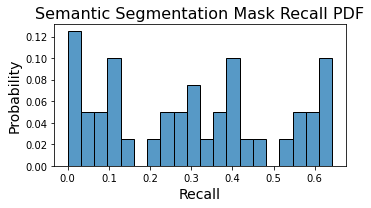

In [47]:
fig, ax = plt.subplots(1, figsize=(5,3))
sns.histplot([rec for rec, prec, f in dict(sorted_recall_mask).values()], bins=20, stat="probability",ax=ax)
ax.set_title("Semantic Segmentation Mask Recall PDF",fontsize=title_fs)
ax.set_xlabel("Recall",fontsize=fs)
ax.set_ylabel("Probability", fontsize=fs)
fig.tight_layout(h_pad=2)
plt.savefig('figures/ss_unet_mask_recall_pdf')
plt.show()

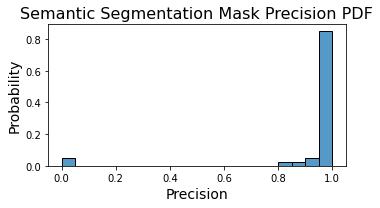

In [48]:
fig, ax = plt.subplots(1, figsize=(5,3))
sns.histplot([prec for rec, prec, f in dict(sorted_precision_mask).values()], bins=20, stat="probability",ax=ax)
ax.set_title("Semantic Segmentation Mask Precision PDF",fontsize=title_fs)
ax.set_xlabel("Precision",fontsize=fs)
ax.set_ylabel("Probability", fontsize=fs)
fig.tight_layout(h_pad=2)
plt.savefig('figures/ss_unet_mask_precision_pdf')
plt.show()

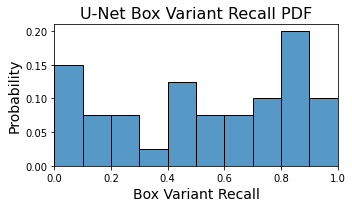

In [49]:
fig, ax = plt.subplots(1, figsize=(5,3))
ax.set_title("U-Net Box Variant Recall PDF",fontsize=16)
ax.set_xlabel("Box Variant Recall",fontsize=fs)
ax.set_ylabel("Probability",fontsize=fs)
ax.set_xlim(0,1)
sns.histplot([a[1] for a in sorted_recall_box], ax=ax, stat="probability", bins=np.arange(0,1.1,0.1))

fig.tight_layout(h_pad=2)
plt.savefig('figures/ss_unet_box_recall_pdf')
plt.show()

In [50]:
fig, ax = plt.subplots(1, figsize=(5,3))
ax.set_title("U-Net Box Variant Precision PDF",fontsize=16)
ax.set_xlabel("Box Variant Precision",fontsize=fs)
ax.set_ylabel("Probability",fontsize=fs)
sns.histplot([a[1] for a in sorted_precision_box], ax=ax, stat="probability", bins=np.arange(0,1.1,0.1))
ax.set_xlim(0,1)
fig.tight_layout(h_pad=2)
plt.savefig('figures/ss_unet_box_precision_pdf')
plt.show()

In [51]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot([rec for rec, prec, f in dict(sorted_recall_mask).values()], bins=20, stat="probability",ax=ax[0])
ax[0].set_title("Semantic Segmentation Mask Recall PDF",fontsize=title_fs)
ax[0].set_xlabel("Recall",fontsize=fs)
ax[0].set_ylabel("Probability", fontsize=fs)

sns.histplot([prec for rec, prec, f in dict(sorted_precision_mask).values()], bins=20, stat="probability",ax=ax[1])
ax[1].set_title("Semantic Segmentation Mask Precision PDF",fontsize=title_fs)
ax[1].set_xlabel("Precision",fontsize=fs)
ax[1].set_ylabel("Probability", fontsize=fs)
plt.show()

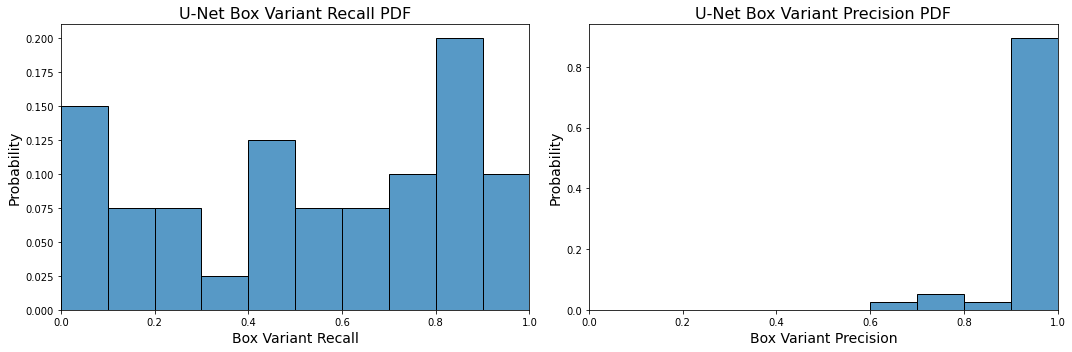

In [52]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("U-Net Box Variant Recall PDF",fontsize=16)
ax[0].set_xlabel("Box Variant Recall",fontsize=fs)
ax[0].set_ylabel("Probability",fontsize=fs)
ax[0].set_xlim(0,1)
sns.histplot([a[1] for a in sorted_recall_box], ax=ax[0], stat="probability", bins=np.arange(0,1.1,0.1))

ax[1].set_title("U-Net Box Variant Precision PDF",fontsize=16)
ax[1].set_xlabel("Box Variant Precision",fontsize=fs)
ax[1].set_ylabel("Probability",fontsize=fs)
sns.histplot([a[1] for a in sorted_precision_box], ax=ax[1], stat="probability", bins=np.arange(0,1.1,0.1))
ax[1].set_xlim(0,1)
plt.tight_layout()
plt.savefig("figures/unet_metrics_hist.png")
plt.show()

In [53]:
lim_dict = {
    "1599036759971": ((0,600),(1450, 2200)),
    "1597995246360": ((1600,2300), (1200, 1550)),
    "1597914138929": ((2150,3250), (1400,3000)),
    "1599031901774": ((2650, 5000), (1300, 1850))
}

In [54]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("U-Net Mask Recall PDF",fontsize=16)
ax[1].set_title("U-Net Mask Precision PDF",fontsize=16)

ax[0].set_xlabel("Mask Recall",fontsize=fs)
ax[1].set_xlabel("Mask Precision",fontsize=fs)
ax[0].set_ylabel("Probability",fontsize=fs)
ax[1].set_ylabel("Probability",fontsize=fs)
sns.histplot([a[1][0] for a in sorted_recall_mask], ax=ax[0], stat="probability", bins=np.arange(0,1.1,0.1))
sns.histplot([a[1][1] for a in sorted_recall_mask], ax=ax[1], stat="probability", bins=np.arange(0,1.1,0.1))
ax[0].set_xlim(0,1)
ax[1].set_xlim(0,1)
plt.tight_layout()
plt.savefig("figures/unet_metrics_mask_hist.png")
plt.show()

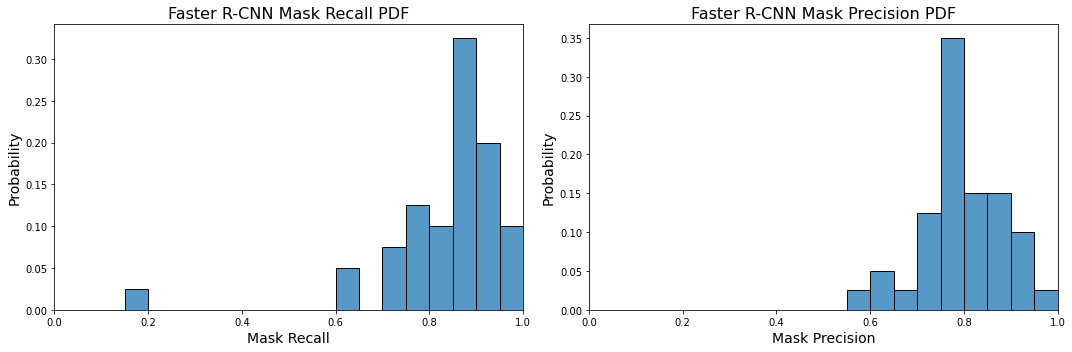

In [55]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title("Faster R-CNN Mask Recall PDF",fontsize=16)
ax[1].set_title("Faster R-CNN Mask Precision PDF",fontsize=16)

ax[0].set_xlabel("Mask Recall",fontsize=fs)
ax[1].set_xlabel("Mask Precision",fontsize=fs)
ax[0].set_ylabel("Probability",fontsize=fs)
ax[1].set_ylabel("Probability",fontsize=fs)
sns.histplot([a[1].mask_recall for a in im_metrics], ax=ax[0], stat="probability", bins=np.arange(0,1.1,0.05))
sns.histplot([a[1].mask_precision for a in im_metrics], ax=ax[1], stat="probability", bins=np.arange(0,1.1,0.05))
ax[0].set_xlim(0,1)
ax[1].set_xlim(0,1)
plt.tight_layout()
plt.savefig("figures/faster_metrics_hist.png")
plt.show()

In [56]:
faster_trainer.set_device('cuda')

1598340934884


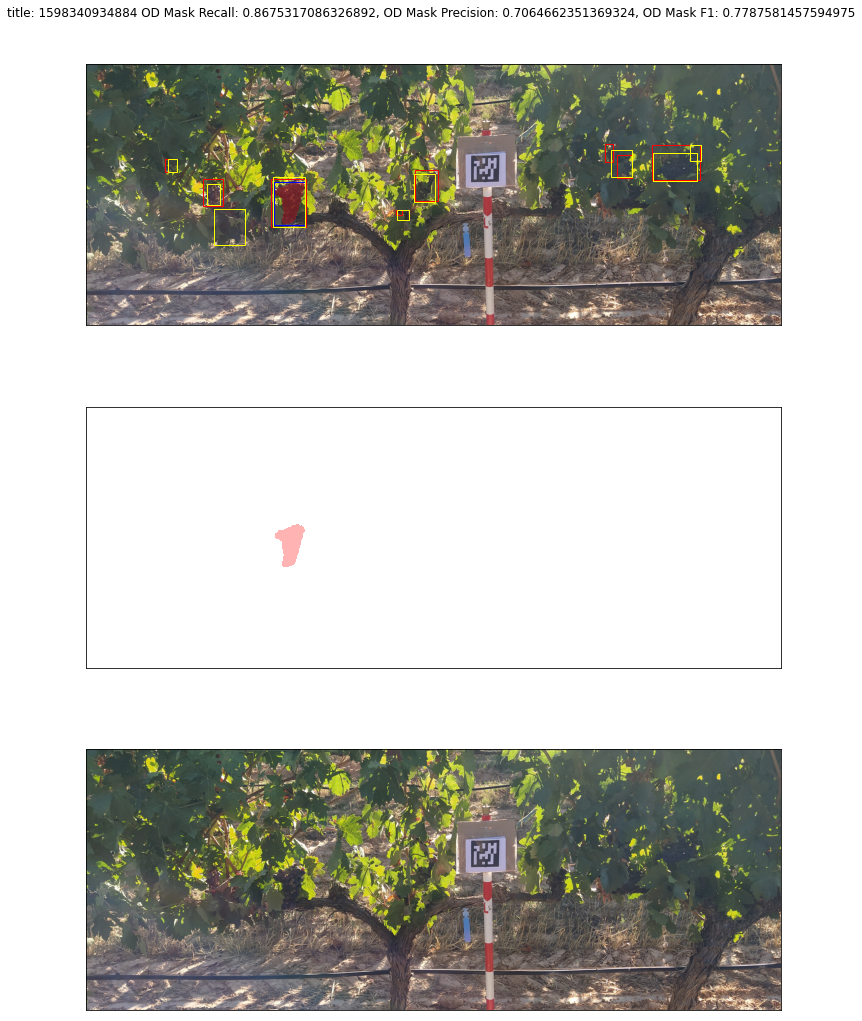

1606994725823


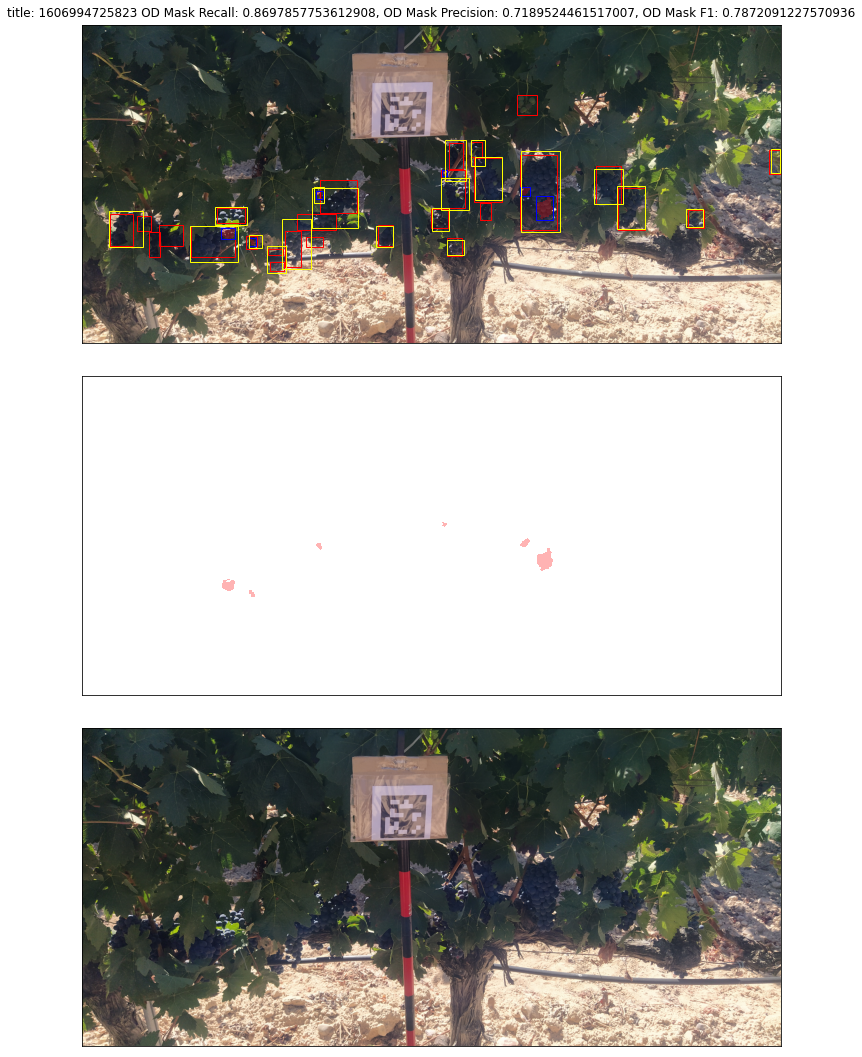

In [57]:
for im_id, metrics in get_sorted_metrics_faster('recall')[20:22]:
    title = f"title: {im_id} OD Mask Recall: {metrics.mask_recall}, OD Mask Precision: {metrics.mask_precision}, OD Mask F1: {metrics.mask_f1_score}"
    print(im_id)
    general_plot(selected_v, im_id, faster_trainer=faster_trainer, title=title, loader=test_loader, positive_mask_color='red', lim_dict=lim_dict)


In [58]:
# This dict can be used to show concrete parts of the images
lim_dict = {
    "1598341506635": ((1500, 2250), (1300, 1800)),
    "1597996402832": ((250, 1300), (750, 1150))
}

In [59]:
_, _, _, precision_unet, recall_unet, _, _, _, _, _ = unet_results[0]

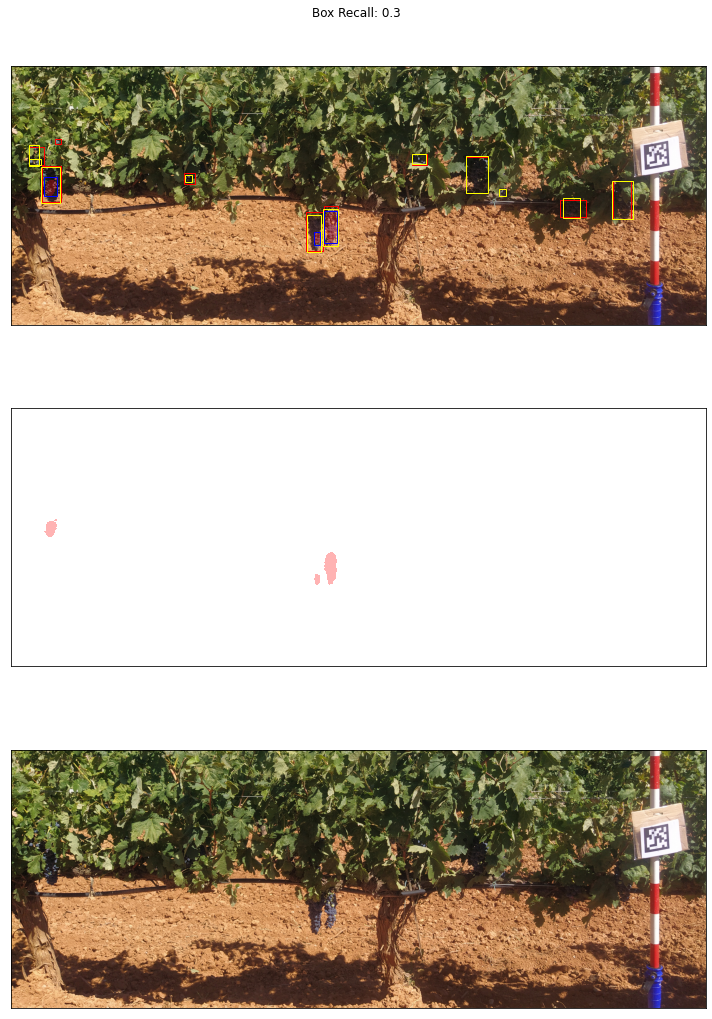

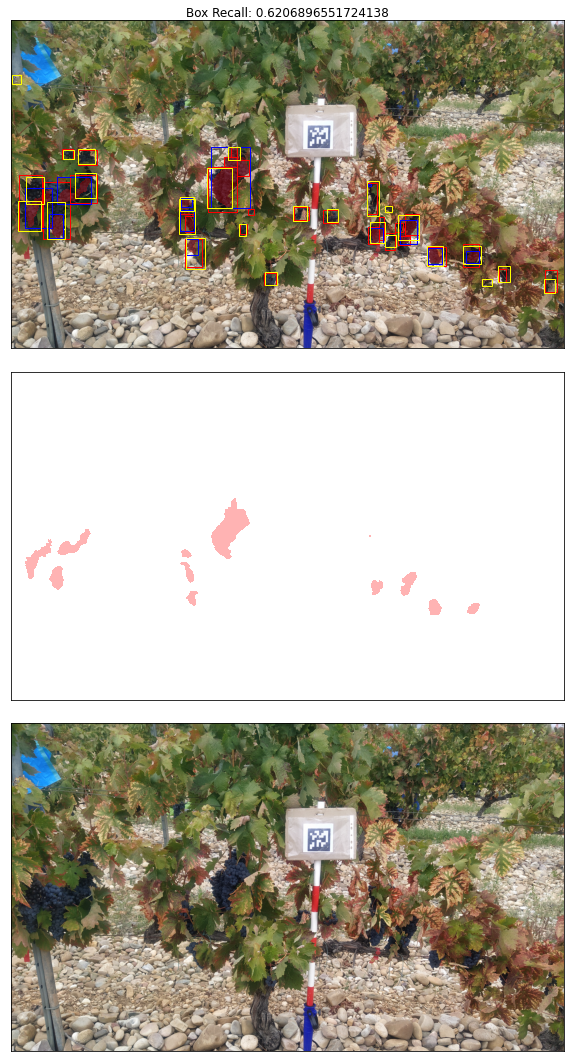

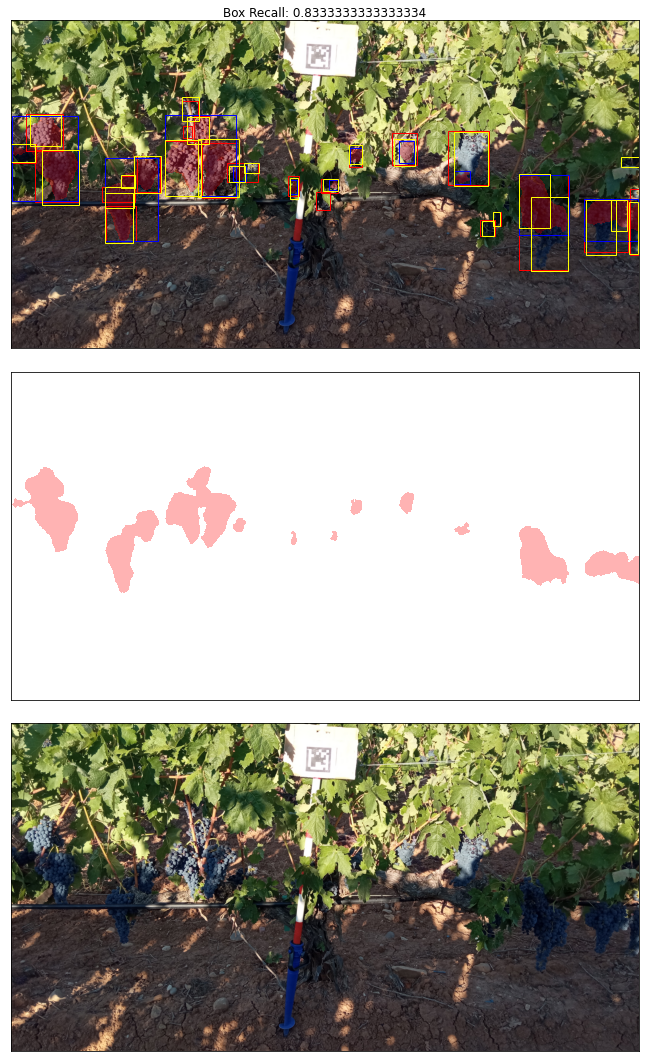

In [65]:
# Minimum box recall images
for im_id, recall in sorted_recall_box[1::10]:
    if im_id  in lim_dict:
        continue
    general_plot(selected_v, im_id, faster_trainer=faster_trainer, title=f"Box Recall: {recall}", loader=test_loader, positive_mask_color='red', with_raw_image=True,lim_dict = lim_dict)


In [61]:
def get_unmatched_boxes(trainer, max_batches=None, find_gt_boxes=False):
    assert trainer.opt.step_batch_size == 1 # Forward only processes one image
    not_matched = {}
    
    for i, (data_d, target_d) in enumerate(trainer.custom_collate(trainer.val_loaders[0][1])):
        if max_batches and i > max_batches:
            break
        data, target = trainer.transform_data(data_d, target_d)
        with torch.no_grad():
            res = trainer.forward(trainer.model, data, target)
        if trainer.opt.model == "ResidualUNet":
            rgb_image = (unorm(data[0].permute((1,2,0)))*255).type(torch.uint8).cpu().numpy()
            crf_res = crf_post_process(np.ascontiguousarray(rgb_image), res[0], *rgb_image.shape[:2])
            mask = crf_res.transpose((1,2,0))[:,:,1] > 0.9
            bboxes = torch.tensor(get_bboxes_from_mask(mask), device=trainer.device)
        else:
            bboxes = res[0]["boxes"]
            
        not_matched = get_matching_bboxes(
            target[0]["boxes"], bboxes, lower_iou_thresh=0.0, upper_iou_thresh=0.0, find_gt_boxes=find_gt_boxes
        )
        not_matched[target[0]["image_id_str"]] = not_matched_curr.cpu().numpy().copy()
    return not_matched

In [62]:
versions=["v1.0.12", "v1.0.14","v1.0.15","v1.0.16"]

v1.0.12


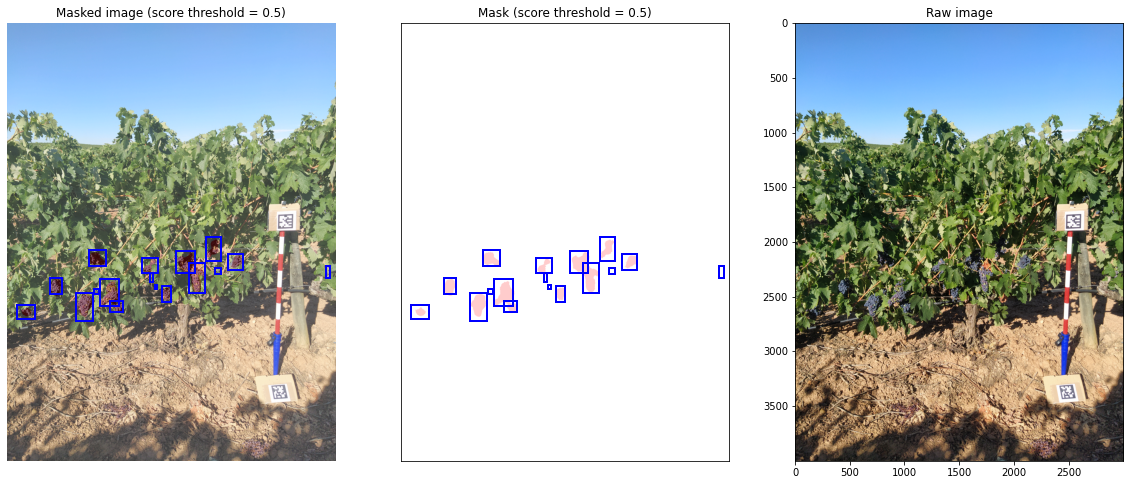

v1.0.14


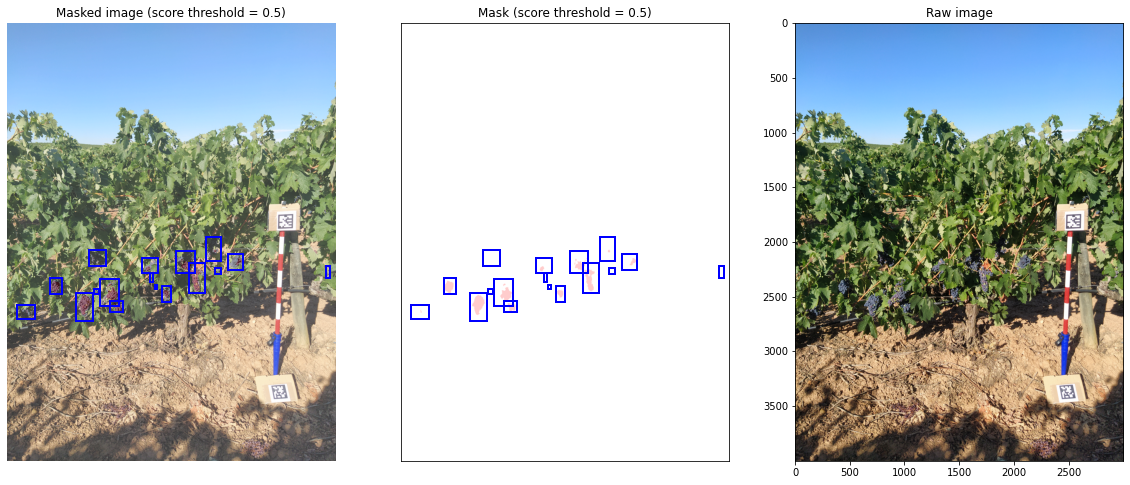

v1.0.15


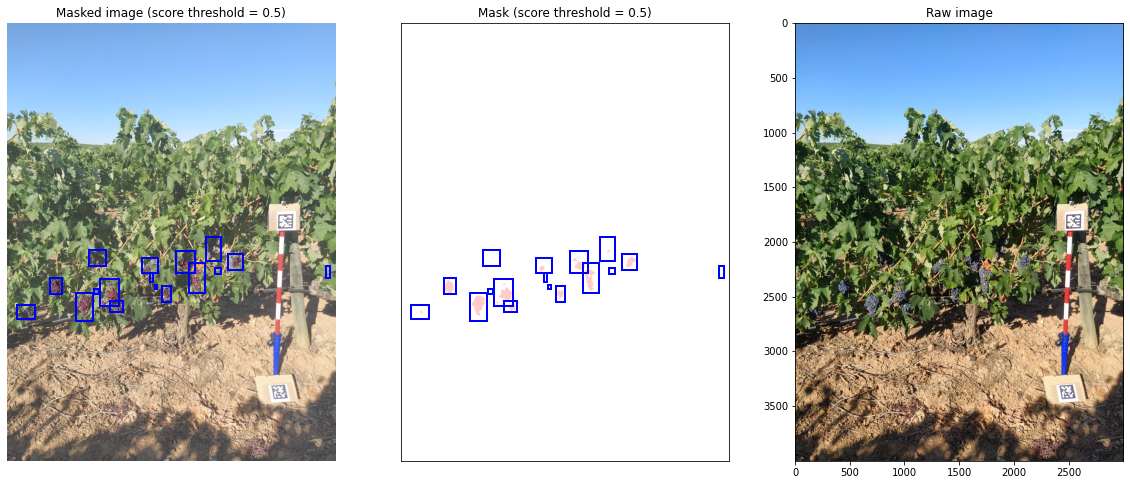

v1.0.16


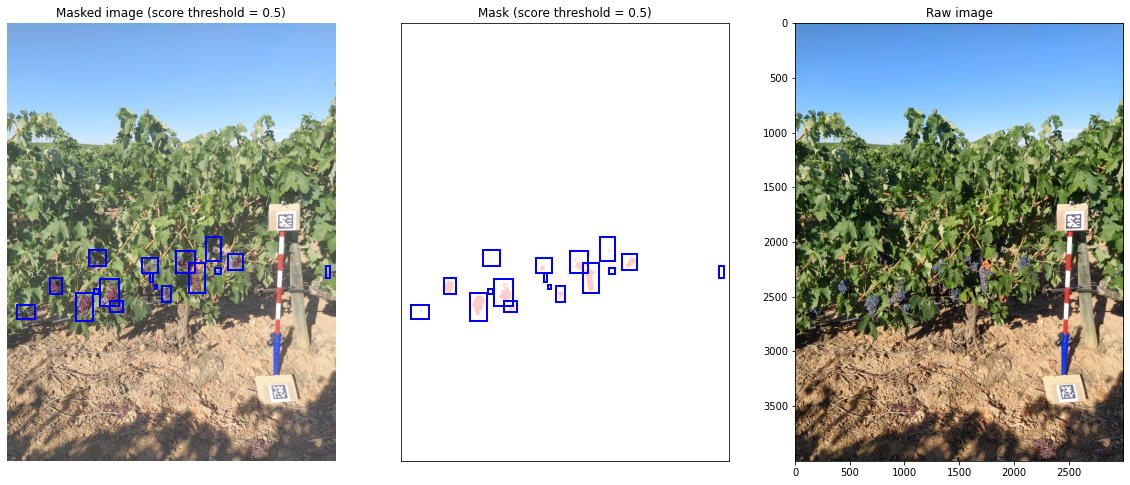

In [63]:

# Stores or shows images (only slices)

save_fig=False
for unet_version in versions:
    print(unet_version)
    store_dir=f"../masks_output/{unet_version}"
    if not os.path.exists(store_dir):
        os.mkdir(store_dir)
    qq=0
    # Assuming batch_size = 1 and no downscaling for the U-Net
    for image_id in trainer.val_loaders[0][1].dataset.ids:
        qq+=1
        data, target = get_item(trainer.val_loaders[0][1], image_id)
        rgb_image=data[0].cpu().numpy()
        final_mask = get_unet_mask_pkl(unet_version, image_id)

        fig, ax = plt.subplots(1,3,figsize=(20,30))
        color1 = colorConverter.to_rgba('white')
        color2 = colorConverter.to_rgba('red')
        cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)
        cmap2._init()
        cmap2._lut[:,-1] = 0.2
        ax[0].imshow(rgb_image)
        ax[0].imshow(final_mask, cmap=cmap2)
        ax[2].imshow(rgb_image)
        ax[1].imshow(final_mask, cmap=cmap2)
        for bbox in target[0]["boxes"]:
            bbox=bbox.int()
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='blue', facecolor='none')
            ax[0].add_patch(rect)
        for bbox in target[0]["boxes"]:
            bbox=bbox.int()
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='blue', facecolor='none')
            ax[1].add_patch(rect)
        ax[0].set_title("Masked image (score threshold = 0.5)")
        ax[1].set_title("Mask (score threshold = 0.5)")
        ax[2].set_title(f"Raw image")
        ax[0].axis('off')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        image_id=target[0]["image_id_str"]
        n_boxes = target[0]["boxes"].shape[0]
        if save_fig:
            plt.tight_layout()
            plt.savefig(os.path.join(store_dir, f'{image_id}.png'), format='png',bbox_inches='tight')
            plt.close()
        else:
            plt.show()

        if not save_fig and qq >= 1:
            break